In [861]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import arviz as az
from sklearn.linear_model import QuantileRegressor
import pymc as pm
import pytensor
import pytensor.tensor as pt
from scipy import stats
import patsy
from torch import nn
import torch
import torch.nn as nn
import torch.optim as optim



In [900]:
# Generate synthetic data
def generate_data(num_samples, seq_length, input_features):
    ''' Function to generate sample data for the heteroscedastic RNN solution '''
    # Generate samples according to batches, sequences length and number of external input features
    # For our example, we'll keep it simple - 1 batch, 1 input features (the target itself)
    x = np.random.randn(num_samples, seq_length, input_features)
    t = np.arange(0,seq_length)
    np.random.seed(1)
    # Generate a time series with weekly monthly and yearly seasonality
    weekly = 1.5*np.sin(2*np.pi*t/7)**3 + 5*np.sin(2*np.pi*t/7)**2 + np.sin(2*np.pi*t/7)*0.5
    weekly = weekly - np.mean(weekly)
    monthly = 0.5*np.sin(2*np.pi*t/30 + 10) + 0.8*np.sin(2*np.pi*t/30 + 10)**3
    monthly = monthly - np.mean(monthly)
    yearly  = 4*np.sin(2*np.pi*t/365)
    yearly = yearly - np.mean(yearly)

    mu = 2*(monthly + weekly + yearly)
    # The variance of the time series has 3 discontinuities. This adds heteroscedasticity to the problem.
    scale = np.repeat(0.1, seq_length)
    scale[100:200] = np.repeat(0.3, 100)
    scale[400:500] = np.repeat(0.5, 100)
    scale[650:730] = np.repeat(0.01, 80)

    # Finally, generate the time series and standardise it to 0-1
    y = np.random.normal(mu*scale, scale=0.5)
    y = (y - np.min(y))/(np.max(y) - np.min(y))
    
    # The input should be a shifted version of the target
    x[0,:,0] = y
    y = x[:,:,:1]
    return x, y

# Create input and target data
num_samples = 1
seq_length = 730
input_features = 1

x, y = generate_data(num_samples, seq_length, input_features)

# Convert numpy arrays to PyTorch tensors
inputs = torch.tensor(x, dtype=torch.float32)
target = torch.tensor(y, dtype=torch.float32)

# Set batch size
batch_size = num_samples


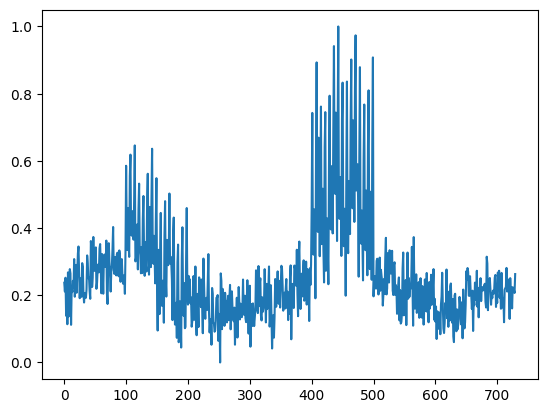

In [901]:
# Plot the target variable for reference
plt.plot(y[0,:,0])

In [903]:
# RNN model
class RNNForecasting(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNNForecasting, self).__init__()

        ''' Init function specifying the Neural Network Architecture
          - Consists of 2 RNN, one to predic the mean and one to predict the standard deviation
        '''
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Mean layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

        # Std layers
        self.rnn_std = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc_std = nn.Linear(hidden_size, output_size)
        # Enforce positivity with the softplus
        self.softplus = nn.Softplus(output_size, output_size)

    def forward(self, x, hidden, hidden_std):
        # Forward pass for the mean
        out, self.hidden = self.rnn(x, hidden)
        out = out[:, -1, :]
        y_h = self.fc(out)
        # Forward pass for the std
        out_, self.hidden_std = self.rnn_std(x, hidden_std)
        out_ = out_[:, -1, :]
        y_std = self.fc_std(out_)
        y_std = self.softplus(y_std)

        return y_h, y_std, hidden, hidden_std

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)


# Training function with fixed rolling window cross-validation
def train_fixed_rolling_window(model, optimizer, inputs, target, window_size):
    model.train()
    optimizer.zero_grad()
    num_windows = inputs.size(1) - window_size

    # Specify a training loop to roll through every time slice, training and predicting for each.
    # The loss is then averaged across all the windows and then the gradients are updated
    total_loss = 0
    for i in range(0,num_windows):
        input_window = inputs[:, i : (i + window_size), :]

        target_window = target[:, (i + window_size): (i + window_size + 1), :]

        # Initialize hidden state
        hidden = model.init_hidden(batch_size)
        hidden_std = model.init_hidden(batch_size)

        # Forward pass
        y_h, y_std, _, _std = model(input_window, hidden, hidden_std)

        # Compute the loss for the current window (Gaussian Negative Log Likelihood)
        loss = nn.functional.gaussian_nll_loss(y_h, target_window, y_std**2)

        loss = torch.mean(loss)

        total_loss += loss

    # Average loss over all windows
    total_loss /= num_windows

    # Backward pass
    total_loss.backward()

    # Update the weights
    optimizer.step()

    return total_loss.item()


# Hyperparameters
input_size = 1
hidden_size = 20
output_size = 1
num_layers = 2
learning_rate = 0.001
epochs = 200

# Create the model
model = RNNForecasting(input_size, hidden_size, output_size, num_layers)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Run the training loop with a rolling window size of 50
window_size = 50
history = np.array([])
for epoch in range(epochs):
    loss = train_fixed_rolling_window(model, optimizer, inputs, target, window_size)
    history = np.append(history, loss)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss:.4f}')
        

Epoch [10/200], Loss: -0.4804
Epoch [20/200], Loss: -0.7509
Epoch [30/200], Loss: -1.1708
Epoch [40/200], Loss: -1.6379
Epoch [50/200], Loss: -1.8303
Epoch [60/200], Loss: -1.9097
Epoch [70/200], Loss: -2.0089
Epoch [80/200], Loss: -2.0359
Epoch [90/200], Loss: -2.0676
Epoch [100/200], Loss: -2.1083
Epoch [110/200], Loss: -2.1548
Epoch [120/200], Loss: -2.1970
Epoch [130/200], Loss: -2.2104
Epoch [140/200], Loss: -2.2331
Epoch [150/200], Loss: -2.2477
Epoch [160/200], Loss: -2.2591
Epoch [170/200], Loss: -2.2668
Epoch [180/200], Loss: -2.2734
Epoch [190/200], Loss: -2.2777
Epoch [200/200], Loss: -2.2836


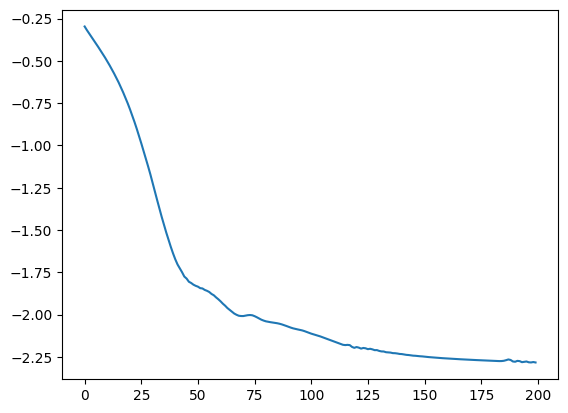

In [906]:
# Plot the loss across the training iterations
plt.plot(history)

In [907]:
# Extract the crossvalidated fit
def extract_fit(model, inputs, target, window_size):
    ''' Function to extract the historical 1-step ahead predictions across the training window'''
    num_windows = inputs.size(1) - window_size
    total_loss = 0
    y_pred = np.array([])
    y_sd = np.array([])
    targets = np.array([])
    for i in range(0,num_windows):
        input_window = inputs[:, i : (i + window_size), :]
        target_window = target[:, (i + window_size): (i + window_size + 1), :]

        targets = np.append(targets, target_window[0,0,0])

        hidden = model.init_hidden(batch_size)
        hidden_std = model.init_hidden(batch_size)

        # Forward pass
        y_u, y_std, _, _std = model(input_window, hidden, hidden_std)
        y_pred = np.append(y_pred, y_u.detach().numpy())
        y_sd = np.append(y_sd, y_std.detach().numpy())
    
    return y_pred, targets, y_sd

y_pred, targets, y_sd = extract_fit(model, inputs, target, window_size)


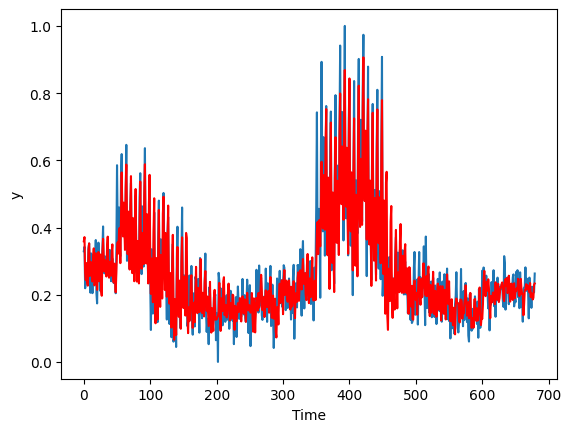

In [912]:
# Plot the predicted mean
plt.plot(targets)
plt.xlabel("Time")
plt.ylabel("y")
plt.plot(y_pred, color="red")
plt.show()

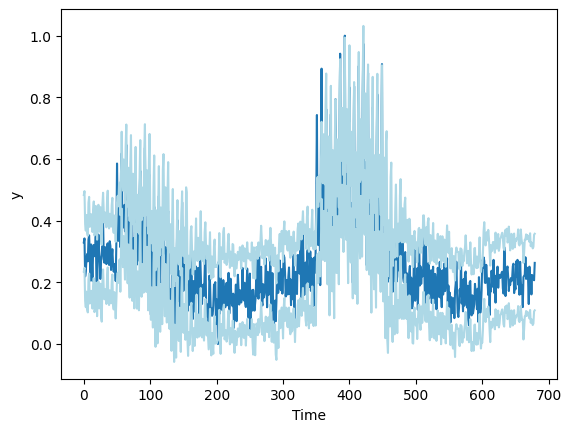

In [926]:
# Approximate 95% prediction interval
plt.plot(targets)
plt.xlabel("Time")
plt.ylabel("y")
#plt.plot(y_pred, color="red")
plt.plot(y_pred + 2*y_sd,  color="#ADD8E6")
plt.plot(y_pred - 2*y_sd, color="#ADD8E6")
plt.show()

In [923]:
# Rough calibration check of the residuals compared to the estimated uncertainty.
res =y_pred - targets
z = (np.where(abs(res) > 2*y_sd)[-1]).shape[0]

print(f"The percentage of points that fall outside of the estimated 95% prediction interval is: {z*100/seq_length}")

The percentage of points that fall outside of the estimated 95% prediction interval is: 4.109589041095891
